# Transformer model for language understanding

FYP: Machine translation models for Cantonese-English pair

In [1]:
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
!pip install -q matplotlib==3.2.2
!pip install -q wget

!pip install -q tensorflow

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

import re
import time
import numpy as np
import matplotlib.pyplot as plt

## Setup input pipeline

In [3]:
import pandas as pd
import glob
import os

all_csv = glob.glob(os.getcwd() + "/train.csv")  

df_test = pd.read_csv(os.getcwd() + "/test.csv", sep='\t', encoding='utf-8')  

df_from_each_file = (pd.read_csv(f, sep='\t', encoding='utf-8') for f in all_csv)
df = pd.concat(df_from_each_file)

# Check for null
df[df['yue'].isnull()]
df = df.dropna()
df_test = df_test.dropna()

YueChar = True
# Delete spaces between n-gram in Cantonese
# Perform Character based tokenization in Cantonese
if YueChar:
    df['yue'] = df['yue'].str.replace(r' ', '')
    df_test['yue'] = df_test['yue'].str.replace(r' ', '')

df.head()

,yue,eng
0,唔準掂同食醃菜唔準坐梳化或者屋企人嘅床上每次經期完咗要洗床單就算床單無汚糟到他們認為我唔純潔...,I was not allowed to touch or eat pickles I wa...
1,佢地扮怪面嚇人,They were making scary faces
2,唔會搞到我哋變得邪惡女人型變成自由黨人咩,turn us into godless sissy liberals
3,呢個模式可以清晰令您瞭解佢哋,So it spells those out in very clean terms
4,幾多萬億掌聲,How many trillions Applause


Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [4]:
import regex as re
def spliteKeyWord(str):
    regex = r"[\u4e00-\ufaff]|[0-9]+|[a-zA-Z]+\'*[a-z]*"
    matches = re.findall(regex, str, re.UNICODE)
    return ' '.join(matches)

if YueChar:
    df['yue'] = df['yue'].apply(lambda x: spliteKeyWord(x))
    df_test['yue'] = df_test['yue'].apply(lambda x: spliteKeyWord(x))
df_test.head()

,yue,eng
0,我 相 信 主,I believe the almighty
1,好 耐 以 嚟 有 發 展 紊 亂 嘅 小 朋 友,For too long now children with developmental d...
2,一 般 會 遇 到 兩 種 反 應,I have two kinds of reactions
3,但 再 諗 下 嗰 位 官 員 未 必 係 唯 一 睇 小 女 性 嘅 人 呢 種 偏 見 ...,But think about this The IMF official is hardl...
4,佢 將 呢 個 病 毒 傳 畀 BB,She passes that virus on to baby


Total number: 253040
Distinct number: 11503
Unique ratio: 0.04545921593423965
{'10-99': 1192, '100-999': 432, '1000+': 32, 2: 975, 3: 393, 1: 7651, 8: 101, 9: 72, 4: 262, 5: 178, 7: 103, 6: 112}


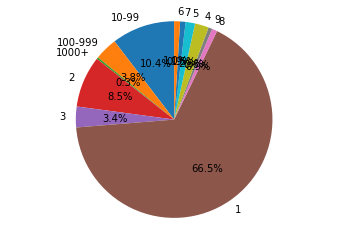

In [5]:
from collections import Counter
l = ''.join(pd.concat([df, df_test])['yue'].values.tolist()).split()
c = Counter(l)
print('Total number:', len(l))
print('Distinct number:', len(c))
print('Unique ratio:', len(c)/len(l))

d = {'10-99':0,  '100-999':0,  '1000+':0}
for k, v in c.items():
    if v<10:
        if v in d:
            d[v] += 1
        else:
            d[v] = 1
    elif v<100:
        d['10-99'] += 1
    elif v<1000:
        d['100-999'] += 1
    else:
        d['1000+'] += 1
print(d)     
labels = list(d.keys())
values = list(d.values())

# plt.pie(values, labels=labels)
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Set translational direction

In [6]:
inp_lang = 'eng'
tar_lang = 'yue'
inp = df[inp_lang]
tar = df[tar_lang]
dataset = tf.data.Dataset.from_tensor_slices((inp.values, tar.values))

## Split dataset into train, test and validation

In [7]:
DATASET_SIZE = len(list(dataset))
# train_size = int(0.8 * DATASET_SIZE)
# test_size = int(0.2 * DATASET_SIZE)

# dataset = dataset.shuffle(DATASET_SIZE)
train_examples = dataset.take(DATASET_SIZE)
# test_examples = dataset.skip(train_size)
# test_examples = remaining.take(test_size)
# val_examples = remaining.skip(test_size)

print('Train size:', len(list(train_examples)))
print('Test size:', len(df_test))
# print('Validation size:', len(list(val_examples)))
print()
print('Total size:', DATASET_SIZE + len(df_test))

Train size: 7848
Test size: 1963

Total size: 9811


In [8]:
for inp, tar in train_examples.take(3):
  print(inp)
  print(tar)
  print('-' * 10)

tf.Tensor(b'I was not allowed to touch or eat pickles I was not allowed to sit on the sofa or some other family member s bed I had to wash my bed sheet after every period even if it was not stained I was considered impure and forbidden from worshipping or touching any object of religious importance You ll find signposts outside temples denying the entry of menstruating girls and women', shape=(), dtype=string)
tf.Tensor(b'\xe5\x94\x94 \xe6\xba\x96 \xe6\x8e\x82 \xe5\x90\x8c \xe9\xa3\x9f \xe9\x86\x83 \xe8\x8f\x9c \xe5\x94\x94 \xe6\xba\x96 \xe5\x9d\x90 \xe6\xa2\xb3 \xe5\x8c\x96 \xe6\x88\x96 \xe8\x80\x85 \xe5\xb1\x8b \xe4\xbc\x81 \xe4\xba\xba \xe5\x98\x85 \xe5\xba\x8a \xe4\xb8\x8a \xe6\xaf\x8f \xe6\xac\xa1 \xe7\xb6\x93 \xe6\x9c\x9f \xe5\xae\x8c \xe5\x92\x97 \xe8\xa6\x81 \xe6\xb4\x97 \xe5\xba\x8a \xe5\x96\xae \xe5\xb0\xb1 \xe7\xae\x97 \xe5\xba\x8a \xe5\x96\xae \xe7\x84\xa1 \xe6\xb1\x9a \xe7\xb3\x9f \xe5\x88\xb0 \xe4\xbb\x96 \xe5\x80\x91 \xe8\xaa\x8d \xe7\x82\xba \xe6\x88\x91 \xe5\x94\x94 \x

In [9]:
sample_examples = []
num_samples = 5

for inp_t, tar_t in train_examples.take(num_samples):
  inp = inp_t.numpy().decode("utf-8")
  tar = tar_t.numpy().decode("utf-8")
  
  print(inp)
  print(tar)
  print('-' * 10)
  
  sample_examples.append((inp, tar))

I was not allowed to touch or eat pickles I was not allowed to sit on the sofa or some other family member s bed I had to wash my bed sheet after every period even if it was not stained I was considered impure and forbidden from worshipping or touching any object of religious importance You ll find signposts outside temples denying the entry of menstruating girls and women
唔 準 掂 同 食 醃 菜 唔 準 坐 梳 化 或 者 屋 企 人 嘅 床 上 每 次 經 期 完 咗 要 洗 床 單 就 算 床 單 無 汚 糟 到 他 們 認 為 我 唔 純 潔 禁 止 我 參 拜 或 者 掂 一 啲 聖 物 你 會 發 現 寺 廟 出 面 有 牌 路 牌 禁 止 正 在 嚟 緊 經 期 嘅 婦 女 進 入
----------
They were making scary faces
佢 地 扮 怪 面 嚇 人
----------
turn us into godless sissy liberals
唔 會 搞 到 我 哋 變 得 邪 惡 女 人 型 變 成 自 由 黨 人 咩
----------
So it spells those out in very clean terms
呢 個 模 式 可 以 清 晰 令 您 瞭 解 佢 哋
----------
How many trillions Applause
幾 多 萬 億 掌 聲
----------


In [10]:
if inp_lang == 'yue':
    if YueChar:
      input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)
    else:
      input_tokenizer = tfds.deprecated.text.TokenTextEncoder(
          ' '.join(inp.numpy().decode("utf-8") for inp, tar in train_examples).split(' ')) 
    target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13)
else:
    if YueChar:
      target_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
          (tar.numpy() for inp, tar in train_examples), target_vocab_size=2**13, max_subword_length=1)
    else:
      target_tokenizer = tfds.deprecated.text.TokenTextEncoder(
          ' '.join(tar.numpy().decode("utf-8") for inp, tar in train_examples).split(' '))
    input_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (inp.numpy() for inp, tar in train_examples), target_vocab_size=2**13)

In [11]:
print(f'{inp_lang}: {input_tokenizer.vocab_size} vocabs')
print(f'{tar_lang}: {target_tokenizer.vocab_size} vocabs')

eng: 7791 vocabs
yue: 3335 vocabs


Check the tokenizers with sample string

In [12]:
# We can use string in dataset
sample_inp = sample_examples[0][0]
sample_tar = sample_examples[0][1]

tokenized_inp = input_tokenizer.encode(sample_inp)
print ('Tokenized string is {}'.format(tokenized_inp))

original_inp = input_tokenizer.decode(tokenized_inp)
print ('The original string: {}'.format(original_inp))

tokenized_tar = target_tokenizer.encode(sample_tar)
print ('Tokenized string is {}'.format(tokenized_tar))

original_tar = target_tokenizer.decode(tokenized_tar)
print ('The original string: {}'.format(original_tar))

Tokenized string is [6, 15, 28, 1290, 2, 2160, 36, 436, 2551, 951, 6, 15, 28, 1290, 2, 1335, 21, 1, 5696, 5, 36, 89, 101, 282, 2248, 7, 1521, 6, 61, 2, 2140, 25, 1521, 5743, 208, 162, 943, 116, 63, 12, 15, 28, 4338, 2573, 6, 15, 2351, 2007, 1122, 3, 4854, 2057, 39, 5395, 1140, 36, 5536, 159, 1971, 4, 2945, 6413, 64, 127, 194, 1728, 1453, 7, 1350, 2878, 951, 1641, 1878, 1, 3906, 85, 4, 6204, 467, 3, 1046]
The original string: I was not allowed to touch or eat pickles I was not allowed to sit on the sofa or some other family member s bed I had to wash my bed sheet after every period even if it was not stained I was considered impure and forbidden from worshipping or touching any object of religious importance You ll find signposts outside temples denying the entry of menstruating girls and women
Tokenized string is [14, 3111, 554, 3111, 980, 3111, 10, 3111, 116, 3111, 2303, 3111, 1225, 3111, 14, 3111, 554, 3111, 583, 3111, 2196, 3111, 153, 3111, 102, 3111, 67, 3111, 331, 3111, 252, 3111,

The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [13]:
for ts in tokenized_inp:
  print ('{} ----> {}'.format(ts, input_tokenizer.decode([ts])))
print()
for ts in tokenized_tar:
  print ('{} ----> {}'.format(ts, target_tokenizer.decode([ts])))

6 ----> I 
15 ----> was 
28 ----> not 
1290 ----> allowed 
2 ----> to 
2160 ----> touch 
36 ----> or 
436 ----> eat 
2551 ----> pick
951 ----> les 
6 ----> I 
15 ----> was 
28 ----> not 
1290 ----> allowed 
2 ----> to 
1335 ----> sit 
21 ----> on 
1 ----> the 
5696 ----> sof
5 ----> a 
36 ----> or 
89 ----> some 
101 ----> other 
282 ----> family 
2248 ----> member 
7 ----> s 
1521 ----> bed 
6 ----> I 
61 ----> had 
2 ----> to 
2140 ----> wash 
25 ----> my 
1521 ----> bed 
5743 ----> sheet 
208 ----> after 
162 ----> every 
943 ----> period 
116 ----> even 
63 ----> if 
12 ----> it 
15 ----> was 
28 ----> not 
4338 ----> stai
2573 ----> ned 
6 ----> I 
15 ----> was 
2351 ----> considered 
2007 ----> imp
1122 ----> ure 
3 ----> and 
4854 ----> forbid
2057 ----> den 
39 ----> from 
5395 ----> worship
1140 ----> ping 
36 ----> or 
5536 ----> touching 
159 ----> any 
1971 ----> object 
4 ----> of 
2945 ----> religious 
6413 ----> importance 
64 ----> You 
127 ----> ll 
194 ----> find 
172

In [14]:
BUFFER_SIZE = 400
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [15]:
def encode(lang1, lang2):
  lang1 = [input_tokenizer.vocab_size] + input_tokenizer.encode(
      lang1.numpy()) + [input_tokenizer.vocab_size+1]

  lang2 = [target_tokenizer.vocab_size] + target_tokenizer.encode(
      lang2.numpy()) + [target_tokenizer.vocab_size+1]
  
  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [16]:
def tf_encode(inp, tar):
  result_inp, result_tar = tf.py_function(encode, [inp, tar], [tf.int64, tf.int64])
  result_inp.set_shape([None])
  result_tar.set_shape([None])

  return result_inp, result_tar

Note: To keep this example small and relatively fast, drop examples with a length of over `40` tokens.

In [17]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [18]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
num_examples = 0
for inp_indices, tar_indices in train_dataset:
  num_examples += 1
print(f"Training size: {num_examples}")

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

df_test = df_test[
    df_test['yue'].apply(lambda x: len(x.split())<MAX_LENGTH) &
    df_test['eng'].apply(lambda x: len(x.split())<MAX_LENGTH) 
]

print(f"Testing size: {len(df_test)}")

Training size: 6634
Testing size: 1696


In [19]:
# Check with train set
inp_indices, tar_indices  = next(iter(train_dataset))
print(inp_indices)
print(tar_indices)

num_examples = 0
for inp_indices, tar_indices in train_dataset:
  # cond1 = len(inp_indices) <= MAX_LENGTH
  # cond2 = len(tar_indices) <= MAX_LENGTH
  # assert cond1 and cond2
  num_examples += 1

print(f"\nAll string are less than {MAX_LENGTH} tokens")
print(f"Total batches: {num_examples}")

tf.Tensor(
[[7791   34    7 ...    0    0    0]
 [7791   97 7792 ...    0    0    0]
 [7791   26   12 ...    0    0    0]
 ...
 [7791   64   84 ...    0    0    0]
 [7791   14  304 ...    0    0    0]
 [7791  120 7792 ...    0    0    0]], shape=(64, 18), dtype=int64)
tf.Tensor(
[[3335  199 3111 ...    0    0    0]
 [3335  122 3111 ...    0    0    0]
 [3335   11 3111 ...    0    0    0]
 ...
 [3335   12 3111 ...    0    0    0]
 [3335  534 3111 ...    0    0    0]
 [3335  197 3111 ...    0    0    0]], shape=(64, 39), dtype=int64)

All string are less than 40 tokens
Total batches: 104


## Positional encoding

In [20]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [21]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


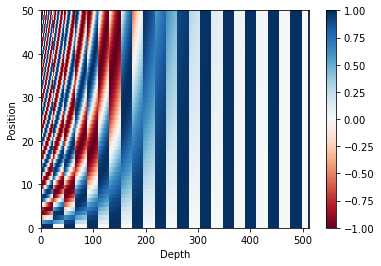

In [22]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [23]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [24]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [25]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [26]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [28]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [29]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [30]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [31]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [32]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [34]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

In [35]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [36]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

### Encoder layer

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [38]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [40]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

In [41]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [42]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [44]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

In [45]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [46]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [47]:
num_layers = 2
d_model = 128
dff = 256
num_heads = 4

input_vocab_size = input_tokenizer.vocab_size + 2
target_vocab_size = target_tokenizer.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [49]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

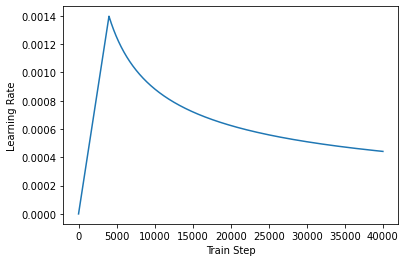

In [50]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [51]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [52]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [53]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [54]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [55]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [56]:
checkpoint_path = "./checkpoints/Trans-4_EngYue"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print ('Latest checkpoint restored!!')

In [57]:
EPOCHS = 100

In [58]:
run_id = f"Trans-4_EngYue_{num_layers}L_{d_model}D_{num_heads}H_{dff}dff"
log_dir = os.path.join(os.path.join(os.getcwd(), 'log'), run_id)
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2021-04-16 00:35:08.875643: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-04-16 00:35:08.875787: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data

In [59]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [60]:
summary_writer = tf.summary.create_file_writer(log_dir)
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  # Save output to TensorBoard
  with summary_writer.as_default():
    tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
    tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.2091 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.0358 Accuracy 0.0078
Epoch 1 Batch 100 Loss 7.6668 Accuracy 0.1104
Epoch 1 Loss 7.6446 Accuracy 0.1135
Time taken for 1 epoch: 112.66881823539734 secs

Epoch 2 Batch 0 Loss 6.8757 Accuracy 0.2331
Epoch 2 Batch 50 Loss 6.6378 Accuracy 0.2248
Epoch 2 Batch 100 Loss 6.4039 Accuracy 0.2241
Epoch 2 Loss 6.3906 Accuracy 0.2235
Time taken for 1 epoch: 81.95030665397644 secs

Epoch 3 Batch 0 Loss 5.8806 Accuracy 0.2119
Epoch 3 Batch 50 Loss 5.6152 Accuracy 0.2248
Epoch 3 Batch 100 Loss 5.3397 Accuracy 0.2237
Epoch 3 Loss 5.3241 Accuracy 0.2239
Time taken for 1 epoch: 83.32644820213318 secs

Epoch 4 Batch 0 Loss 4.7271 Accuracy 0.1992
Epoch 4 Batch 50 Loss 4.5423 Accuracy 0.2251
Epoch 4 Batch 100 Loss 4.3495 Accuracy 0.2243
Epoch 4 Loss 4.3371 Accuracy 0.2243
Time taken for 1 epoch: 84.74069237709045 secs

Epoch 5 Batch 0 Loss 3.8951 Accuracy 0.2135
Epoch 5 Batch 50 Loss 3.7698 Accuracy 0.2249
Epoch 5 Batch 100 Loss 3.6567 Accu

Epoch 36 Batch 0 Loss 0.7364 Accuracy 0.3725
Epoch 36 Batch 50 Loss 0.7349 Accuracy 0.4066
Epoch 36 Batch 100 Loss 0.7152 Accuracy 0.4075
Epoch 36 Loss 0.7139 Accuracy 0.4082
Time taken for 1 epoch: 80.69405484199524 secs

Epoch 37 Batch 0 Loss 0.7506 Accuracy 0.3931
Epoch 37 Batch 50 Loss 0.7035 Accuracy 0.4161
Epoch 37 Batch 100 Loss 0.6866 Accuracy 0.4155
Epoch 37 Loss 0.6871 Accuracy 0.4158
Time taken for 1 epoch: 79.70275449752808 secs

Epoch 38 Batch 0 Loss 0.6573 Accuracy 0.3951
Epoch 38 Batch 50 Loss 0.6680 Accuracy 0.4190
Epoch 38 Batch 100 Loss 0.6502 Accuracy 0.4199
Epoch 38 Loss 0.6501 Accuracy 0.4192
Time taken for 1 epoch: 89.21196913719177 secs

Epoch 39 Batch 0 Loss 0.6686 Accuracy 0.4292
Epoch 39 Batch 50 Loss 0.6460 Accuracy 0.4209
Epoch 39 Batch 100 Loss 0.6287 Accuracy 0.4210
Epoch 39 Loss 0.6281 Accuracy 0.4213
Time taken for 1 epoch: 84.35142588615417 secs

Epoch 40 Batch 0 Loss 0.6529 Accuracy 0.4268
Epoch 40 Batch 50 Loss 0.6084 Accuracy 0.4237
Epoch 40 Batch 10

Saving checkpoint for epoch 70 at ./checkpoints/Final_Trans_EngYue_Char_2\ckpt-14
Epoch 70 Loss 0.1753 Accuracy 0.4844
Time taken for 1 epoch: 72.35081005096436 secs

Epoch 71 Batch 0 Loss 0.1462 Accuracy 0.4775
Epoch 71 Batch 50 Loss 0.1722 Accuracy 0.4874
Epoch 71 Batch 100 Loss 0.1669 Accuracy 0.4849
Epoch 71 Loss 0.1665 Accuracy 0.4851
Time taken for 1 epoch: 72.16736626625061 secs

Epoch 72 Batch 0 Loss 0.1741 Accuracy 0.4518
Epoch 72 Batch 50 Loss 0.1672 Accuracy 0.4909
Epoch 72 Batch 100 Loss 0.1656 Accuracy 0.4837
Epoch 72 Loss 0.1650 Accuracy 0.4837
Time taken for 1 epoch: 71.5810821056366 secs

Epoch 73 Batch 0 Loss 0.1658 Accuracy 0.4712
Epoch 73 Batch 50 Loss 0.1676 Accuracy 0.4857
Epoch 73 Batch 100 Loss 0.1639 Accuracy 0.4843
Epoch 73 Loss 0.1637 Accuracy 0.4840
Time taken for 1 epoch: 71.59866070747375 secs

Epoch 74 Batch 0 Loss 0.1348 Accuracy 0.4918
Epoch 74 Batch 50 Loss 0.1557 Accuracy 0.4869
Epoch 74 Batch 100 Loss 0.1524 Accuracy 0.4830
Epoch 74 Loss 0.1523 Accura

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the `input_tokenizer`. Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == target_tokenizer.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

In [61]:
def evaluate(inp_sentence):
  start_token = [input_tokenizer.vocab_size]
  end_token = [input_tokenizer.vocab_size + 1]
  
  inp_sentence = start_token + input_tokenizer.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  decoder_input = [target_tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == target_tokenizer.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [62]:
# Chinese font in matplotlib
from matplotlib.font_manager import FontProperties
import wget
# !wget -qO taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
# !mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.6/dist-packages/matplotlib//mpl-data/fonts/ttf
# chinese = FontProperties(fname=r'/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')
if not os.path.isfile('taipei_sans_tc_beta.ttf'):
    wget.download('https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download', 'taipei_sans_tc_beta.ttf')
chinese = FontProperties(fname=r'taipei_sans_tc_beta.ttf')

In [63]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = input_tokenizer.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    # show Chinese character
    fontdict = {"fontproperties": chinese}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[input_tokenizer.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([target_tokenizer.decode([i]) for i in result 
                        if i < target_tokenizer.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [64]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = target_tokenizer.decode([i for i in result 
                                            if i < target_tokenizer.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

As the globe spins
跟 住 個 地 球 會 轉 

Input: As the globe spins
Predicted translation: 你 會 依 套 受 到 嘅 菠 菜 同 西


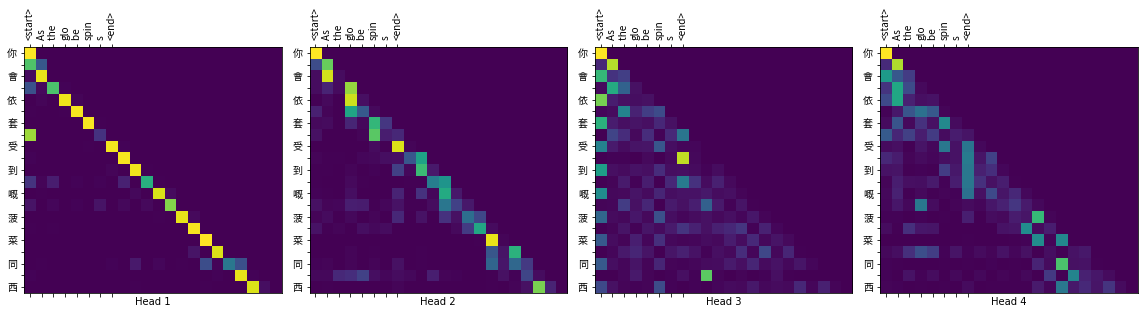

In [65]:
row = df_test.sample()
inp = row[inp_lang].values[0]
tar = row[tar_lang].values[0]
print(inp)
print(tar, '\n')

translate(inp, plot='decoder_layer1_block1')

In [66]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1262464   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  824704    
_________________________________________________________________
dense_119 (Dense)            multiple                  430473    
Total params: 2,517,641
Trainable params: 2,517,641
Non-trainable params: 0
_________________________________________________________________


In [67]:
def translateTest(sentence):
  result, attention_weights = evaluate(sentence)
  
  sentence = input_tokenizer.encode(sentence)
  sentence = ' '.join([input_tokenizer.decode([i]) for i in sentence])
  predicted_sentence = target_tokenizer.decode([i for i in result 
                                            if i < target_tokenizer.vocab_size])  

#   print('Input: {}'.format(sentence))
#   print('Predicted translation: {}'.format(predicted_sentence))
  return sentence, predicted_sentence

In [68]:
TotalTime = time.time()
start = time.time()

ori = []
ref = []
can = []
num_test = 0

for index, row in df_test.iterrows():
    inp = row[inp_lang]
    tar = row[tar_lang]
    num_test += 1
    o, pre = translateTest(inp)
    ori.append(o)
    ref.append(tar)
    if YueChar:
        can.append(spliteKeyWord(pre))
    else:
        can.append(pre)
    if num_test % 50 == 0:
        print(f'Progress: {num_test} / {len(df_test)} in {time.time()-start} s')
        start = time.time()
        
print(f'\nToTal: {num_test} / {len(df_test)} in {time.time()-TotalTime} s')

Progress: 50 / 1696 in 202.19793462753296 s
Progress: 100 / 1696 in 52.245479345321655 s
Progress: 150 / 1696 in 50.09973216056824 s
Progress: 200 / 1696 in 51.27521634101868 s
Progress: 250 / 1696 in 48.53520679473877 s
Progress: 300 / 1696 in 49.57944178581238 s
Progress: 350 / 1696 in 55.912912130355835 s
Progress: 400 / 1696 in 49.03492569923401 s
Progress: 450 / 1696 in 51.9145290851593 s
Progress: 500 / 1696 in 46.919734477996826 s
Progress: 550 / 1696 in 50.371296644210815 s
Progress: 600 / 1696 in 53.601725578308105 s
Progress: 650 / 1696 in 54.52885818481445 s
Progress: 700 / 1696 in 56.0418004989624 s
Progress: 750 / 1696 in 53.223400831222534 s
Progress: 800 / 1696 in 57.159459352493286 s
Progress: 850 / 1696 in 54.67940163612366 s
Progress: 900 / 1696 in 48.675177812576294 s
Progress: 950 / 1696 in 46.20428919792175 s
Progress: 1000 / 1696 in 41.93953776359558 s
Progress: 1050 / 1696 in 49.20257902145386 s
Progress: 1100 / 1696 in 40.37971043586731 s
Progress: 1150 / 1696 i

In [69]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

import random
ran = random.randint(1, len(ref))
print(ori[ran])
print(ref[ran])
print(can[ran])

smoothie = SmoothingFunction().method4
print('BLEU:', sentence_bleu(ref[ran], can[ran], smoothing_function=smoothie)*100)

there  on  the  sub  machine  gun
放 咗 喺 佢 哋 嘅 衝 鋒 槍 上
以 撒 哈 拉 以 南 嘅 原 來
BLEU: 20.413678198935372


In [71]:
# Sentence-based and average score
# score = 0
# for i in range(len(ref)):
#     r = [ref[i].split()]
#     c = can[i].split()
#     score += sentence_bleu(r, c, smoothing_function=smoothie)*100
# print('BLEU-s:', score/len(ref))

# Corpus based, summing all nominator and denominator before division
r = [[r.split()] for r in ref]
c = [c.split() for c in can]
score = corpus_bleu(r, c, smoothing_function=smoothie)*100
print('BLEU-c:', score)

BLEU-c: 5.076931717161718
